In [1]:
import numpy as np 
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

/home/enigma/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/enigma/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/enigma/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/enigma/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/enigma/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype

## Importing playstore reviews dataset


In [2]:
data = pd.read_csv('googleplaystore_user_reviews.csv')

data.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [3]:
data=data[['Translated_Review','Sentiment']]
data.head()

,Translated_Review,Sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
2,NaN,NaN
3,Works great especially going grocery store,Positive
4,Best idea us,Positive


## Preprocessing data

In [4]:
data['Translated_Review']=data['Translated_Review'].str.lower()
data.head()

,Translated_Review,Sentiment
0,i like eat delicious food. that's i'm cooking ...,Positive
1,this help eating healthy exercise regular basis,Positive
2,NaN,NaN
3,works great especially going grocery store,Positive
4,best idea us,Positive


In [5]:
data['Translated_Review']=data['Translated_Review'].str.replace('[^a-zA-Z0-9]', ' ')
data.head(10)

,Translated_Review,Sentiment
0,i like eat delicious food that s i m cooking ...,Positive
1,this help eating healthy exercise regular basis,Positive
2,NaN,NaN
3,works great especially going grocery store,Positive
4,best idea us,Positive
5,best way,Positive
6,amazing,Positive
7,NaN,NaN
8,looking forward app,Neutral
9,it helpful site it help foods get,Neutral


In [6]:

# data['Translated_Review'] = data['Translated_Review'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['Sentiment'] == 'Positive'].size)
print(data[ data['Sentiment'] == 'Negative'].size)



47996
16542


In [7]:
# for idx,row in data.iterrows():
#     row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')

## Removing rows with no reviews/ NaN values

In [8]:
data=data.dropna()
data.shape

(37427, 2)

## Removing non alphanumeric characters

In [9]:
data['Translated_Review'] = data.Translated_Review.str.strip().str.split('[\W_]+')
data['Translated_Review'].head()

0    [i, like, eat, delicious, food, that, s, i, m,...
1    [this, help, eating, healthy, exercise, regula...
3    [works, great, especially, going, grocery, store]
4                                     [best, idea, us]
5                                          [best, way]
Name: Translated_Review, dtype: object

## Tokenizing Dataset

In [10]:
tokenizer.fit_on_texts(data['Translated_Review'].values)

In [11]:
X = tokenizer.texts_to_sequences(data['Translated_Review'].values)

In [12]:
X = pad_sequences(X)
X.shape

(37427, 277)

# APPLYING LSTM 

In [24]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 277, 128)          256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 277, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 591       
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
Y = pd.get_dummies(data['Sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(25076, 277) (25076, 3)
(12351, 277) (12351, 3)


## Load the trained model

In [13]:
from keras.models import model_from_json

# Model reconstruction from JSON file
with open('sentimentAnalysis.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('sentiment.h5')

# Training Model

### if you want to retrain the model run this cell

In [26]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)

Epoch 1/7
 - 350s - loss: 0.4784 - acc: 0.8146
Epoch 2/7
 - 343s - loss: 0.2515 - acc: 0.9167
Epoch 3/7
 - 345s - loss: 0.2066 - acc: 0.9340
Epoch 4/7
 - 347s - loss: 0.1825 - acc: 0.9416
Epoch 5/7
 - 349s - loss: 0.1623 - acc: 0.9492
Epoch 6/7
 - 354s - loss: 0.1452 - acc: 0.9550
Epoch 7/7
 - 351s - loss: 0.1263 - acc: 0.9612


In [27]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.23
acc: 0.93


In [33]:
 #save model
  print("Saving model to disk \n")

  mp = "sentiment.h5"
  model.save(mp)

Saving model to disk 



In [35]:
# Save the model architecture
with open('sentimentAnalysis.json', 'w') as f:
    f.write(model.to_json())

In [41]:
X[0].shape

(277,)

## Importing Assignment Data

In [14]:
assignment= pd.read_excel('DataAnalystIntern_Assignment.xlsx',sheet_name=1)
assignment.head()

,App,Translated_Review,Sentiment
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,NaN
1,10 Best Foods for You,This help eating healthy exercise regular basis,NaN
2,10 Best Foods for You,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,NaN
4,10 Best Foods for You,Best idea us,NaN


In [15]:
assignment=assignment.drop(['Sentiment'],axis=1)

In [16]:
assignment['Translated_Review']=assignment['Translated_Review'].str.lower()

In [17]:
assignment['Translated_Review']=assignment['Translated_Review'].str.replace('[^a-zA-Z0-9]', ' ')
assignment=assignment.dropna()

In [18]:
assignment.head(10)

,App,Translated_Review
0,10 Best Foods for You,i like eat delicious food that s i m cooking ...
1,10 Best Foods for You,this help eating healthy exercise regular basis
3,10 Best Foods for You,works great especially going grocery store
4,10 Best Foods for You,best idea us
5,10 Best Foods for You,best way
6,10 Best Foods for You,amazing
8,10 Best Foods for You,looking forward app
9,10 Best Foods for You,it helpful site it help foods get
10,10 Best Foods for You,good you
11,10 Best Foods for You,useful information the amount spelling errors ...


In [19]:
X_check=tokenizer.texts_to_sequences(assignment['Translated_Review'].values)

In [20]:
X_check = pad_sequences(X_check, maxlen=277, dtype='int32', value=0)

In [21]:
a=model.predict(X_check)

In [22]:
def answer(sentiment):
    if np.argmax(sentiment) == 0:
        return ("negative",sentiment[0]*100)
    elif np.argmax(sentiment) == 1:
        return ("neutral",sentiment[1]*100)
    elif np.argmax(sentiment) == 2:
        return ("positive",sentiment[2]*100)

In [23]:
result=[]
probability=[]

In [24]:
for ai in a:
    result.append(answer(ai)[0])
    probability.append(answer(ai)[1])

In [25]:
assignment["Sentiment"]=result
assignment["Sentiment_Probability"]=probability

In [26]:
assignment.head(25)

,App,Translated_Review,Sentiment,Sentiment_Probability
0,10 Best Foods for You,i like eat delicious food that s i m cooking ...,positive,99.991333
1,10 Best Foods for You,this help eating healthy exercise regular basis,positive,99.880779
3,10 Best Foods for You,works great especially going grocery store,positive,99.943727
4,10 Best Foods for You,best idea us,positive,99.925262
5,10 Best Foods for You,best way,positive,99.951744
6,10 Best Foods for You,amazing,positive,99.945194
8,10 Best Foods for You,looking forward app,neutral,40.581429
9,10 Best Foods for You,it helpful site it help foods get,neutral,98.198754
10,10 Best Foods for You,good you,positive,99.918658
11,10 Best Foods for You,useful information the amount spelling errors ...,positive,99.579054


/home/enigma/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


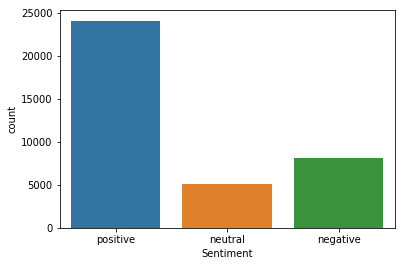

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(assignment['Sentiment'])


In [28]:
assignment.to_csv('SentimentSolution.csv')

In [36]:
dataset=assignment[['App','Translated_Review','Sentiment']]

In [40]:
dataset.to_excel('SentimentSheet.xlsx',encoding='utf-8')

In [49]:
b=['its okay ']

In [50]:
b=tokenizer.texts_to_sequences(b)
b = pad_sequences(b, maxlen=277, dtype='int32', value=0)

In [51]:
bans=model.predict(b)

In [52]:
bans

array([[3.2803169e-04, 6.3906494e-04, 9.9903297e-01]], dtype=float32)